In [405]:
import math
import numpy as np
import os

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
sns.set_style("ticks")
sns.set_context("paper")
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [406]:
three_d_points = np.array([
    [-0.08, -2.30333333, 1.19666667],  # Top right solar panel
    [-0.15666667, -0.84333333, 1.19666667],  # Top left solar panel
    [-0.08, -2.30333333, -0.78333333],  # Bottom right solar panel
    [-0.15666667, -0.84333333, -0.78333333],  # Bottom left solar panel
    [-0.24333333, 1.03, -0.65333333],  # Bottom left satellite
])

three_d_points_names = [
    'Top right solar panel',
    'Top left solar panel',
    'Bottom right solar panel',
    'Bottom left solar panel',
    'Bottom left satellite'
]


def get_rotated_point(roll, pitch, yaw, point=None):
    if point is None:
        point = [-0.08, -2.30333333, 1.19666667]

    r_roll = np.array([[1, 0, 0],
                       [0, math.cos(roll / 180 * math.pi), -math.sin(roll / 180 * math.pi)],
                       [0, math.sin(roll / 180 * math.pi), math.cos(roll / 180 * math.pi)]])

    r_pitch = np.array([[math.cos(pitch / 180 * math.pi), 0, math.sin(pitch / 180 * math.pi)],
                        [0, 1, 0],
                        [-math.sin(pitch / 180 * math.pi), 0, math.cos(pitch / 180 * math.pi)]])

    r_yaw = np.array([[math.cos(yaw / 180 * math.pi), -math.sin(yaw / 180 * math.pi), 0],
                      [math.sin(yaw / 180 * math.pi), math.cos(yaw / 180 * math.pi), 0],
                      [0, 0, 1]])

    rotation_matrix = r_yaw @ r_pitch @ r_roll

    rotated_3d_points = np.dot(rotation_matrix, point)

    return rotated_3d_points

In [407]:
folder = "../test_images/dynamic_unknowndeg_0to360_5degstep/"
suffixes = ['_linefit_eps2']
colors = ['red', 'green', 'blue']
nice_suffixes = [s.removeprefix("_").replace('_', ' ').capitalize() for s in suffixes]


In [408]:
df_true = pd.read_csv(folder + "real_scores.csv")
df_true = df_true.rename(columns={'correct_roll': 'roll', 'correct_pitch': 'pitch', 'correct_yaw':
    'yaw'})
df_true['img_number'] = df_true.index
df_true['suffix'] = 'true'
df_true

,roll,pitch,yaw,img_number,suffix
0,127.970000,-79.560000,-44.000000,0,true
1,123.295573,-78.244572,-44.152291,1,true
2,119.068439,-76.935369,-44.763274,2,true
3,115.161870,-75.638750,-45.707437,3,true
4,111.491226,-74.359729,-46.901282,4,true
...,...,...,...,...,...
68,157.623186,-84.620406,-54.433702,68,true
69,147.366750,-83.432329,-48.971823,69,true
70,139.573127,-82.170727,-45.978678,70,true
71,133.288987,-80.872993,-44.502381,71,true


In [409]:
df_guess = pd.read_csv(folder + "guesses_linefit_eps2.csv")
df_guess

,img_number,roll,pitch,yaw,x,y,z,roll_min,roll_max,pitch_min,pitch_max,yaw_min,yaw_max,x_min,x_max,y_min,y_max,z_min,z_max
0,0,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-16.000000,16.000000,-97.550000,-81.550000,71.000000,87.000000,-0.400000,0.400000,-0.400000,0.400000,-0.400000,0.400000
1,1,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-52.000000,52.000000,-115.550000,-63.550000,53.000000,105.000000,-1.300000,1.300000,-1.300000,1.300000,-1.300000,1.300000
2,2,-13.034087,-114.679567,93.617511,0.232176,0.147120,-0.180287,-21.034087,-5.034087,-118.679567,-110.679567,89.617511,97.617511,0.032176,0.432176,-0.052880,0.347120,-0.380287,0.019713
3,3,-16.891141,-115.237541,92.408362,0.233947,0.150911,-0.251622,-24.891141,-8.891141,-119.237541,-111.237541,88.408362,96.408362,0.033947,0.433947,-0.049089,0.350911,-0.451622,-0.051622
4,4,-21.609360,-115.594826,92.129775,0.234995,0.151062,-0.357326,-29.609360,-13.609360,-119.594826,-111.594826,88.129775,96.129775,0.034995,0.434995,-0.048938,0.351062,-0.557326,-0.157326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,-724.847941,-110.968673,116.419237,0.197053,0.055303,-0.076424,-731.826503,-717.869380,-111.885458,-110.051888,109.284872,123.553602,0.182224,0.211881,0.045241,0.065365,-0.289939,0.137090
140,140,-726.049827,-113.186372,112.688631,0.182080,0.055292,-0.303749,-732.389382,-719.710271,-114.269196,-112.103548,106.191441,119.185822,0.164627,0.199533,0.046006,0.064577,-0.519221,-0.088276
141,141,-730.849497,-114.562454,112.719378,0.201072,0.051222,-0.185218,-735.194662,-726.504331,-115.644922,-113.479985,108.206898,117.231857,0.180425,0.221719,0.040316,0.062128,-0.421511,0.051075
142,142,-731.518039,-115.527716,108.161232,0.195444,0.067742,-0.274765,-735.606168,-727.429909,-116.625480,-114.429953,103.866596,112.455869,0.174724,0.216165,0.055040,0.080443,-0.505202,-0.044328


In [410]:
df = pd.read_csv(folder + "fine_scores_linefit_eps2.csv")
df

,img_number,iterations,loss,roll,pitch,yaw,x,y,z
0,0,1316,4.139997e+02,3.393564,-97.550000,86.708737,0.122971,0.037604,-0.400000
1,1,721,2.782886e-11,-13.034087,-114.679567,93.617511,0.232176,0.147120,-0.180287
2,2,462,8.072226e-12,-16.891141,-115.237541,92.408362,0.233947,0.150911,-0.251622
3,3,525,7.323234e-09,-21.609360,-115.594826,92.129775,0.234995,0.151062,-0.357326
4,4,448,1.544616e+00,-29.199139,-116.454249,95.029600,0.240697,0.123665,-0.362278
...,...,...,...,...,...,...,...,...,...
139,139,462,4.451941e-03,-721.074127,-111.885458,112.674700,0.182224,0.049358,-0.253972
140,140,427,3.638598e-02,-726.554922,-113.262709,113.378753,0.199533,0.046006,-0.148595
141,141,511,4.736086e-10,-727.895046,-114.246778,109.526987,0.195044,0.061650,-0.224991
142,142,287,2.677383e+00,-728.706072,-114.429953,105.400274,0.198595,0.080443,-0.166648


In [411]:
df_guess

,img_number,roll,pitch,yaw,x,y,z,roll_min,roll_max,pitch_min,pitch_max,yaw_min,yaw_max,x_min,x_max,y_min,y_max,z_min,z_max
0,0,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-16.000000,16.000000,-97.550000,-81.550000,71.000000,87.000000,-0.400000,0.400000,-0.400000,0.400000,-0.400000,0.400000
1,1,0.000000,-89.550000,79.000000,0.000000,0.000000,0.000000,-52.000000,52.000000,-115.550000,-63.550000,53.000000,105.000000,-1.300000,1.300000,-1.300000,1.300000,-1.300000,1.300000
2,2,-13.034087,-114.679567,93.617511,0.232176,0.147120,-0.180287,-21.034087,-5.034087,-118.679567,-110.679567,89.617511,97.617511,0.032176,0.432176,-0.052880,0.347120,-0.380287,0.019713
3,3,-16.891141,-115.237541,92.408362,0.233947,0.150911,-0.251622,-24.891141,-8.891141,-119.237541,-111.237541,88.408362,96.408362,0.033947,0.433947,-0.049089,0.350911,-0.451622,-0.051622
4,4,-21.609360,-115.594826,92.129775,0.234995,0.151062,-0.357326,-29.609360,-13.609360,-119.594826,-111.594826,88.129775,96.129775,0.034995,0.434995,-0.048938,0.351062,-0.557326,-0.157326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,-724.847941,-110.968673,116.419237,0.197053,0.055303,-0.076424,-731.826503,-717.869380,-111.885458,-110.051888,109.284872,123.553602,0.182224,0.211881,0.045241,0.065365,-0.289939,0.137090
140,140,-726.049827,-113.186372,112.688631,0.182080,0.055292,-0.303749,-732.389382,-719.710271,-114.269196,-112.103548,106.191441,119.185822,0.164627,0.199533,0.046006,0.064577,-0.519221,-0.088276
141,141,-730.849497,-114.562454,112.719378,0.201072,0.051222,-0.185218,-735.194662,-726.504331,-115.644922,-113.479985,108.206898,117.231857,0.180425,0.221719,0.040316,0.062128,-0.421511,0.051075
142,142,-731.518039,-115.527716,108.161232,0.195444,0.067742,-0.274765,-735.606168,-727.429909,-116.625480,-114.429953,103.866596,112.455869,0.174724,0.216165,0.055040,0.080443,-0.505202,-0.044328


In [412]:
def plot_guess(guess_type, df=df_guess):
    sns.lineplot(data=df, x='img_number', y=guess_type, color='blue', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_min', color='red', ci=None)
    sns.lineplot(data=df, x='img_number', y=guess_type + '_max', color='green', ci=None)
    sns.scatterplot(data=df, x='img_number', y=guess_type, color='black')
    plt.legend(['Guess', 'Min', 'Max', 'Lowest loss estimate'])
    plt.title('SMA ' + guess_type + ' guesses')
    plt.xlabel('Image number')
    plt.ylabel(guess_type + ' (deg)')
    plt.show()

In [413]:
df_guess_mod = df_guess.copy()
# df_guess['roll'] go from -180 to 180
df_guess_mod['roll'] = df_guess['roll'] % 360 - 180
# pitch goes from 0 - 180 to -90 - 90
df_guess_mod['pitch'] = df_guess['pitch'] % 360 - 180
df_guess_mod['yaw'] = df_guess['yaw'] % 360 - 180

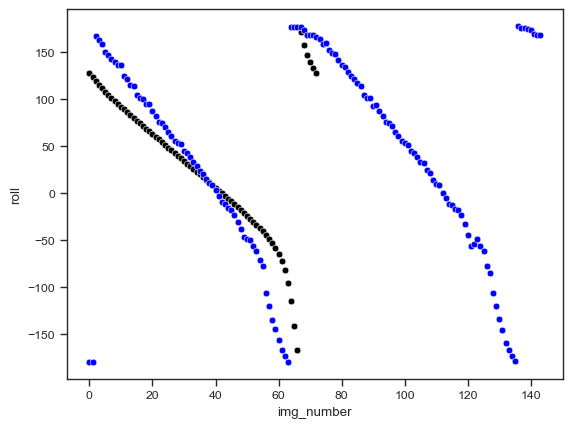

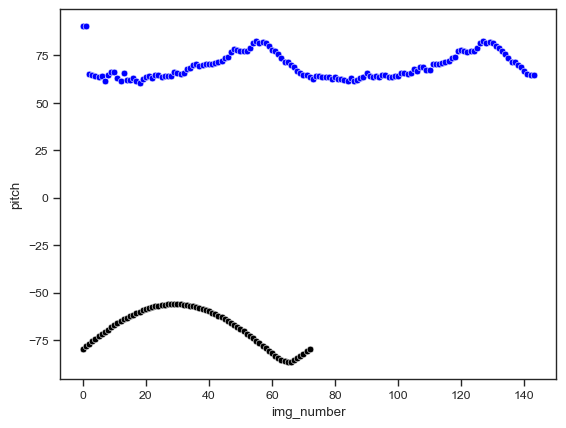

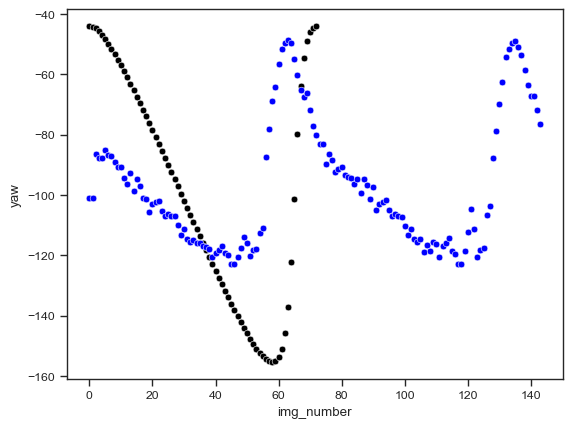

In [414]:
for guess_type in ['roll', 'pitch', 'yaw']:
    sns.scatterplot(data=df_true, x='img_number', y=guess_type, color='black')
    sns.scatterplot(data=df_guess_mod, x='img_number', y=guess_type, color='blue')
    plt.show()

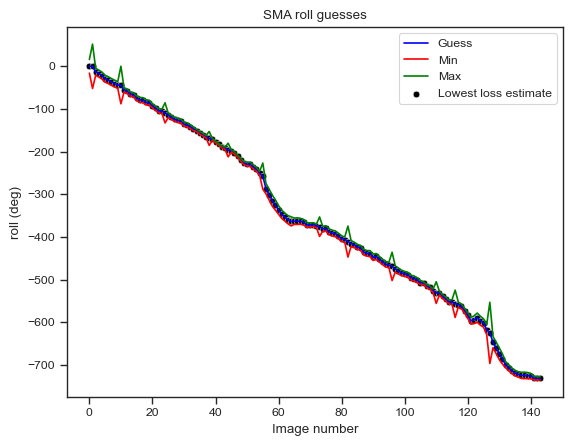

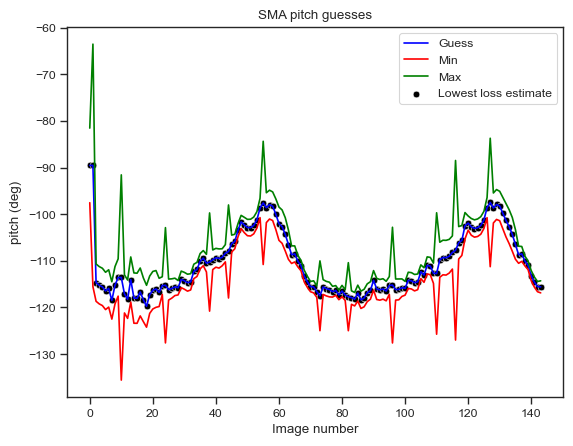

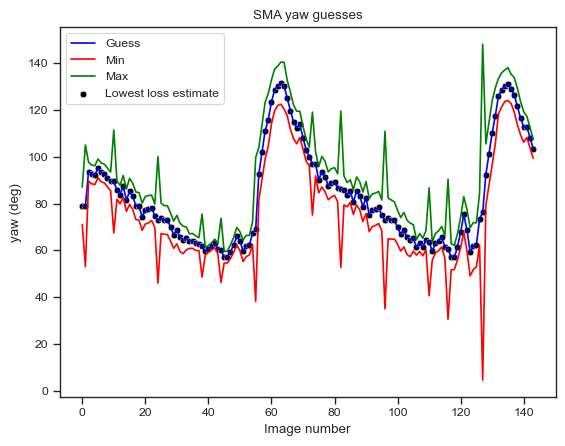

In [415]:
for guess_type in ['roll', 'pitch', 'yaw']:
    plot_guess(guess_type)

In [416]:
# def plot_reg(guess_type):
#     sns.regplot(data=df_guess, x='true_' + guess_type, y='guess_' + guess_type, ci=None)
#     plt.show()

In [417]:
# for guess_type in ['roll', 'pitch', 'yaw']:
#     plot_reg(guess_type)

In [418]:
df_rotated_points = pd.DataFrame()
for i, point in enumerate(three_d_points):
    df_local = df.apply(
        lambda row: get_rotated_point(row['roll'], row['pitch'], row['yaw'], point),
        axis=1, result_type='expand').rename(columns={0: 'x', 1: 'y', 2: 'z'})
    df_local['img_number'] = df['img_number']
    df_local['3d_point'] = three_d_points_names[i]
    df_rotated_points = pd.concat([df_local, df_rotated_points])

In [419]:
df_rotated_points.to_csv(folder + 'rotated_points.csv', index=False)

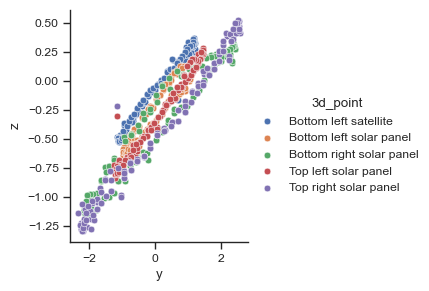

In [420]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'y', 'z').add_legend()

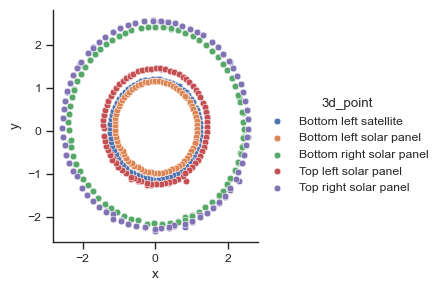

In [421]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'x', 'y').add_legend()

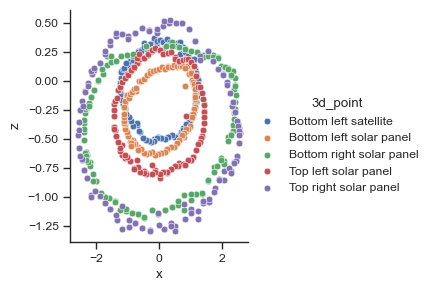

In [422]:
sns.FacetGrid(df_rotated_points, hue='3d_point').map(sns.scatterplot, 'x', 'z').add_legend()